In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import keras
import pandas as pd

# Problem 1: Feature Importance in Iris Classification
We return to the iris dataset from last week. Load it into the notebook and make a pair plot.

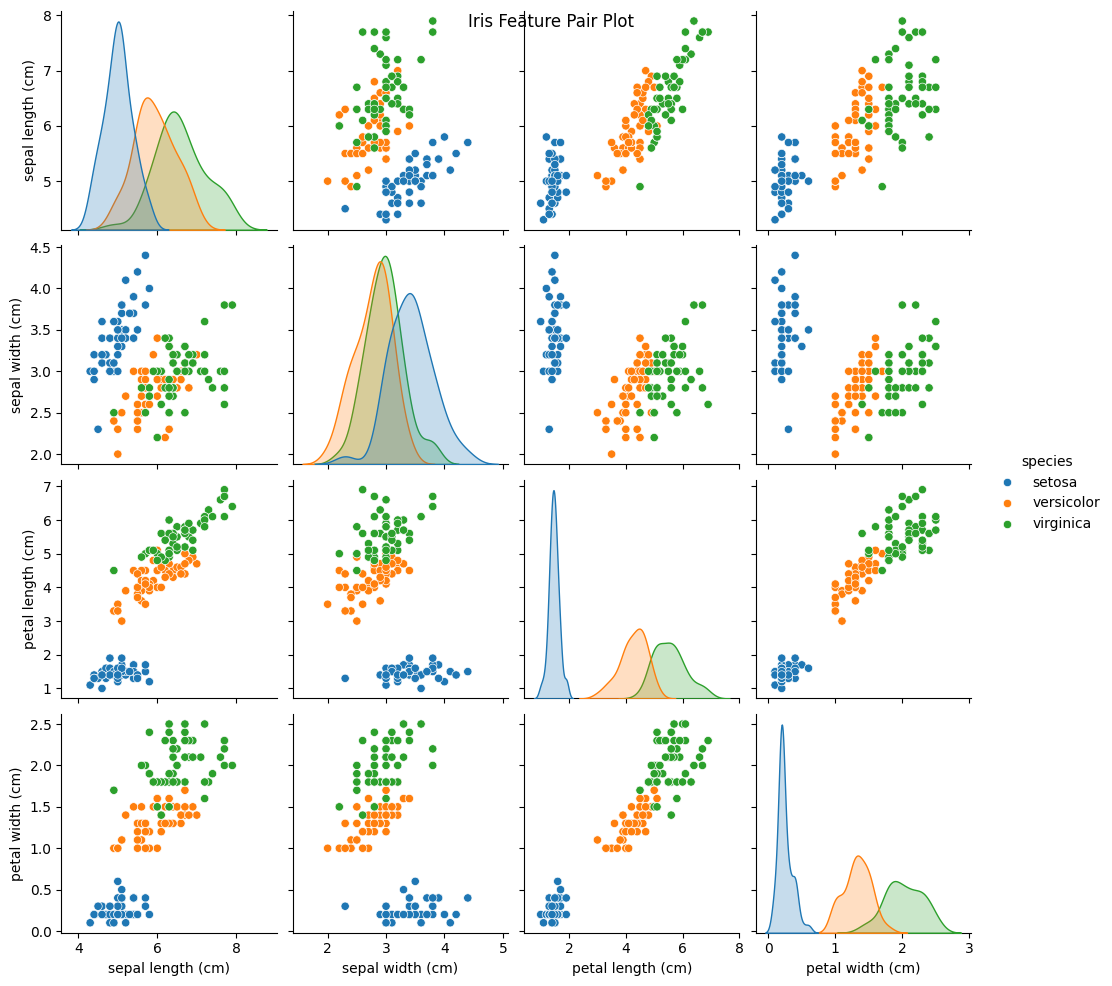

In [11]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the iris dataset
iris = datasets.load_iris()

# Create a DataFrame with feature data
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Add species labels
df['species'] = iris.target
df['species'] = df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Create a pair plot
sns.pairplot(df, hue='species', markers='o')
plt.suptitle("Iris Feature Pair Plot")
plt.show()

This time, let's classify it using a random forest. Initialize and train the random forest classifer using cross validation. Repeat the above plot with the predicted classifications and calculate the overall accuracy.

Overall Accuracy of Random Forest (CV): 0.97


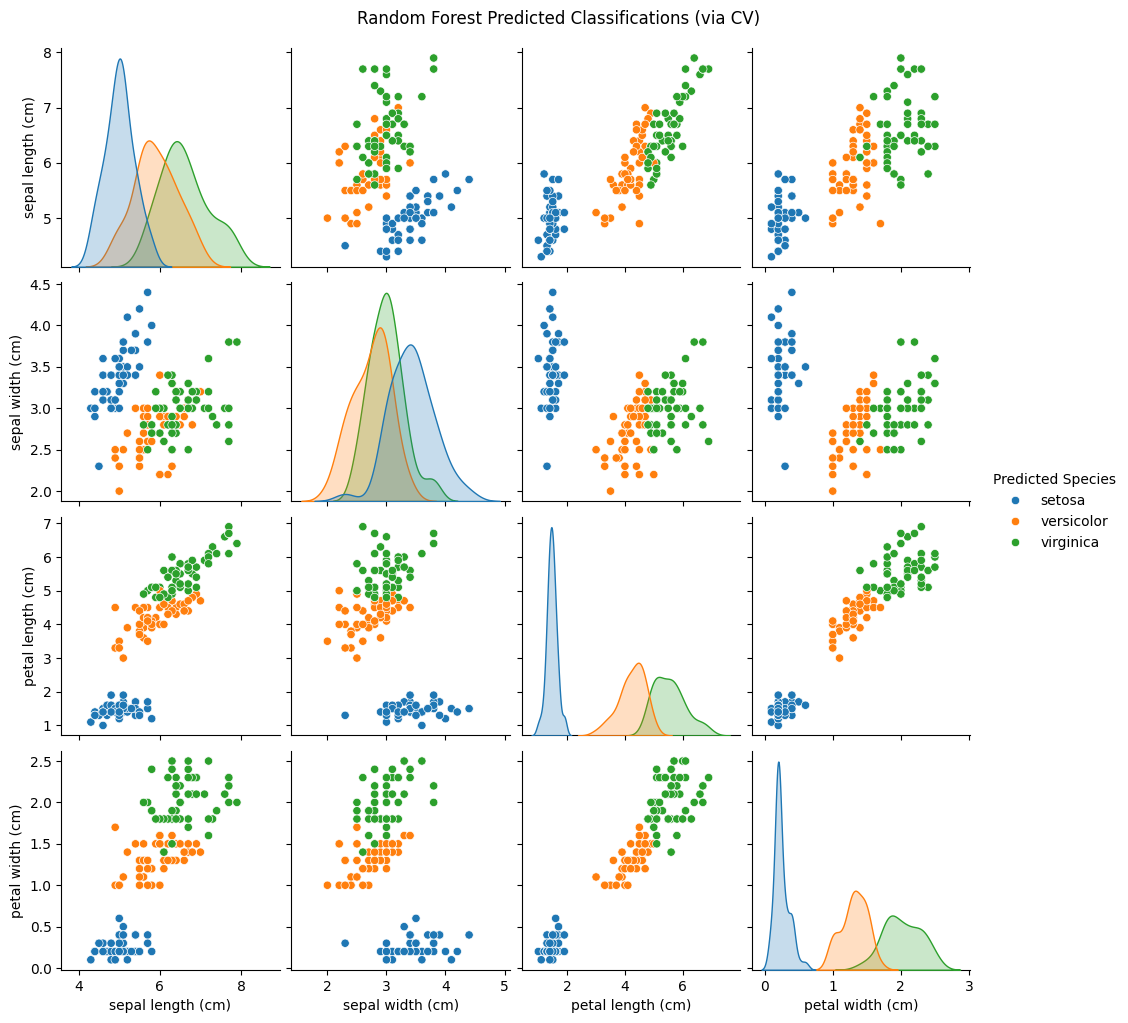

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

#Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
predicted = cross_val_predict(rf, X, y, cv=5)

#Accuracy score
accuracy = accuracy_score(y, predicted)
print(f"Overall Accuracy of Random Forest (CV): {accuracy:.2f}")

#Create DataFrame with predictions for plotting
df = pd.DataFrame(X, columns=feature_names)
df['Predicted Species'] = predicted
df['Predicted Species'] = df['Predicted Species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Plotting
sns.pairplot(df, hue='Predicted Species', markers='o')
plt.suptitle("Random Forest Predicted Classifications (via CV)", y=1.02)
plt.show()


Calculate the mean decrease in impurity and the permutation importance for each feature and plot them (*hint:* `plt.barh`). Which feature(s) seem to be the most useful for classification? Does this agree with your intuition from the plots?

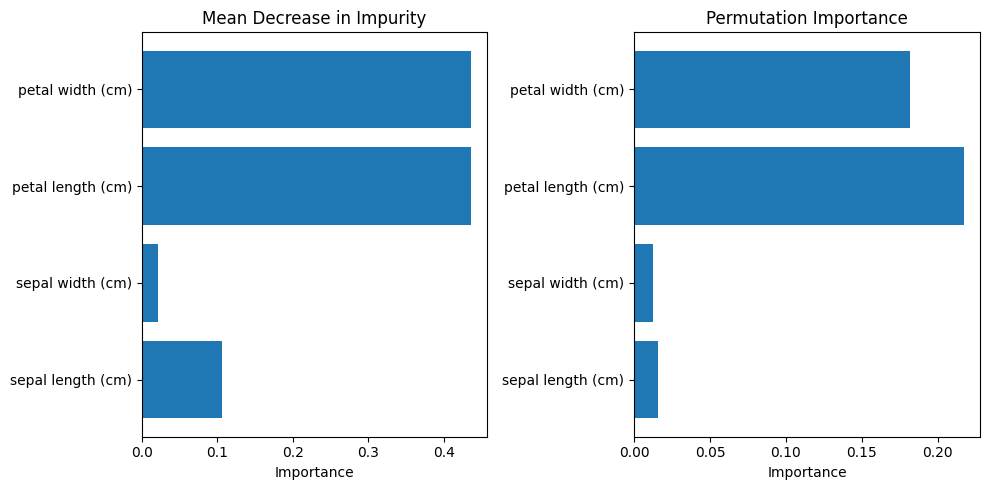

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

feature_names = iris.feature_names

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

mdi_importances = rf.feature_importances_

perm_result = permutation_importance(rf, X, y, n_repeats=30, random_state=42)
perm_importances = perm_result.importances_mean

# Plotting
plt.figure(figsize=(10, 5))

# MDI
plt.subplot(1, 2, 1)
plt.barh(feature_names, mdi_importances)
plt.title('Mean Decrease in Impurity')
plt.xlabel('Importance')

# Permutation
plt.subplot(1, 2, 2)
plt.barh(feature_names, perm_importances)
plt.title('Permutation Importance')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()


*Complete*
Yes, it matches the intuition from the pair plots. Petal features are more informative for classification.

 However, note from the pair plot that the petal length and width are strongly correlated. Pick one of these features and remove it from the data set. Then recalculate the accuracy and the feature importance using only 3 features. How do these change, and do the changes make sense given what you know about the data set?

Accuracy ': 0.90


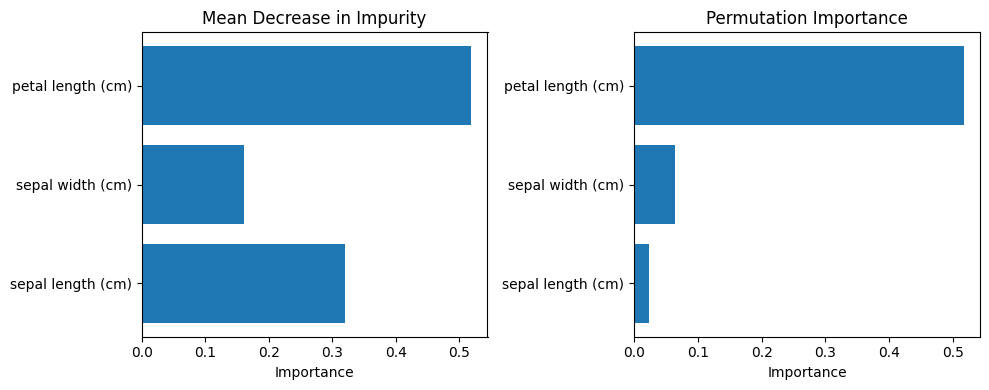

In [15]:
from sklearn.model_selection import train_test_split

feature_names = iris.feature_names

remove_index = feature_names.index("petal width (cm)")
X_reduced = np.delete(X, remove_index, axis=1)
reduced_feature_names = feature_names[:remove_index] + feature_names[remove_index + 1:]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Train Random Forest
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Accuracy
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy ': {accuracy:.2f}")

# Compute feature importances
mdi = rfc.feature_importances_
pi = permutation_importance(rfc, X_test, y_test, n_repeats=10, random_state=42)
perm_imp = pi.importances_mean

# Ploting
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].barh(reduced_feature_names, mdi)
axes[0].set_title("Mean Decrease in Impurity")
axes[0].set_xlabel("Importance")

axes[1].barh(reduced_feature_names, perm_imp)
axes[1].set_title("Permutation Importance")
axes[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()


*Complete*
After removing petal width, the model accuracy dropped from 100% to 90%. This makes sense because petal width was one of the most important features. The model now relies more on petal length.

# Problem 2: Efficient Classification of a Higher Dimensional Data Set

As much time as we've spent on the iris data set, it is much simpler to understand and easier to classify than almost any data set you will encounter in the real world. Let's instead work with the wine data set, which includes 13 chemical and physical measurements of samples of wine from three different (anonymous) vineyards in Italy. Start by reading it in and plotting it. What do you notice about this data set? Are there any single features that divide the three classes cleanly? Will the ranges of the features cause any problems for our classifiers?

(178, 14)
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  class  
0 

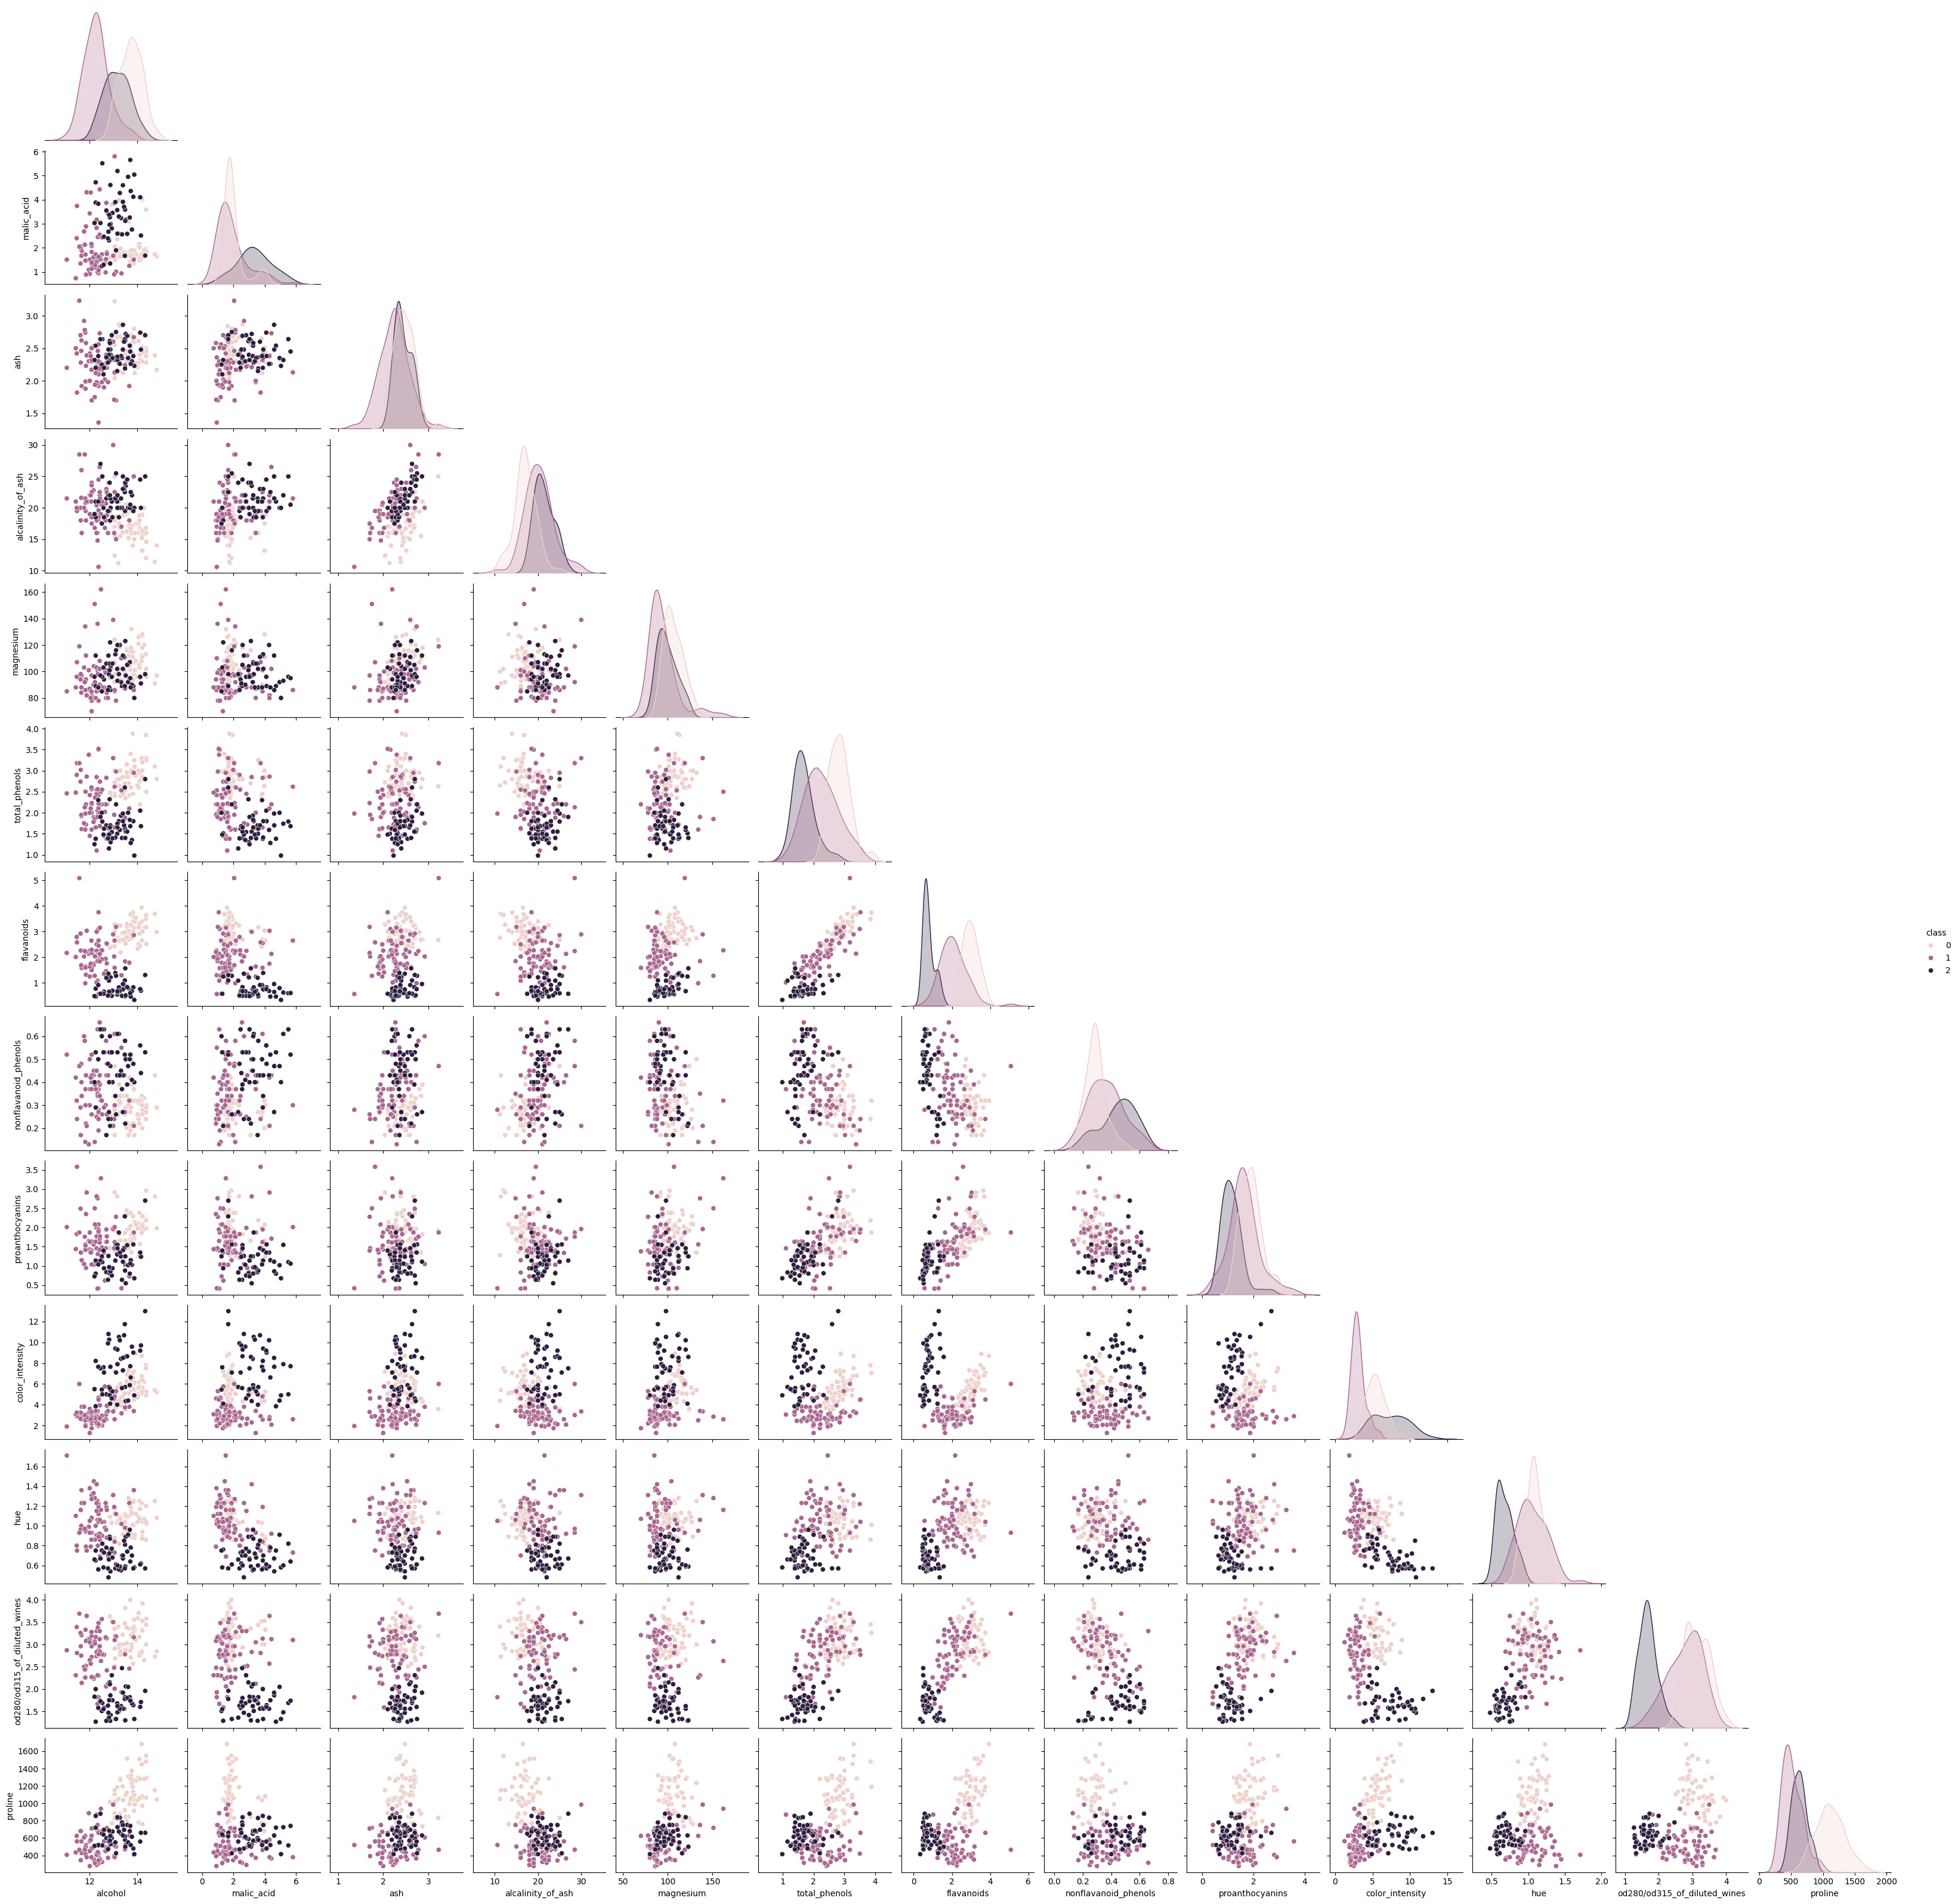

In [17]:
# Load the dataset
wine =  datasets.load_wine()
x = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target

x['class'] = y

print(x.shape)
print(x.head())

sns.pairplot(x, hue='class', corner=True)
plt.show()

*Complete*
The wine dataset shows that while some features help separate the classes, many others overlap and do not clearly distinguish them. No single feature divides all three classes cleanly, so combining multiple features is nessesary.

In the end, we would like to understand how our classifier works, so let's try to reduce the number of features to something more manageable. Apply a dimensionality reduction technique and decide how many features we can make do with. (This is intentionally very open-ended to make you think about it!) Comment on what you're doing.

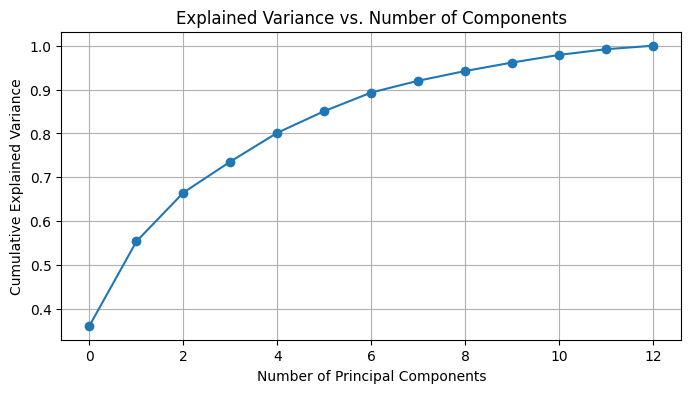

In [26]:
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA

# Load the wine dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


Using your newly engineered features, train a support vector machine with cross validation and calculate the accuracy.

In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Use first 2 principal components for simplicity
X_reduced = X_pca[:, :2]

# Create a pipeline with scaling and SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale'))

# Perform and compute accuracy
scores = cross_val_score(svm_model, X_reduced, y, cv=5)

# Print
print(f"Cross-validated accuracy (mean ± std): {scores.mean():.2f} ± {scores.std():.2f}")


Cross-validated accuracy (mean ± std): 0.97 ± 0.01


Lastly, because this is the interpretability notebook, we want to gain some understanding of how this classification procedure actually worked. Make a graph of how your new features relate to the original input features. Based on the graph, which of the original features are most influential in the final classification? Does your answer differ for different classes? How much of the total sample variance does each of the new features explain?

<Figure size 1000x600 with 0 Axes>

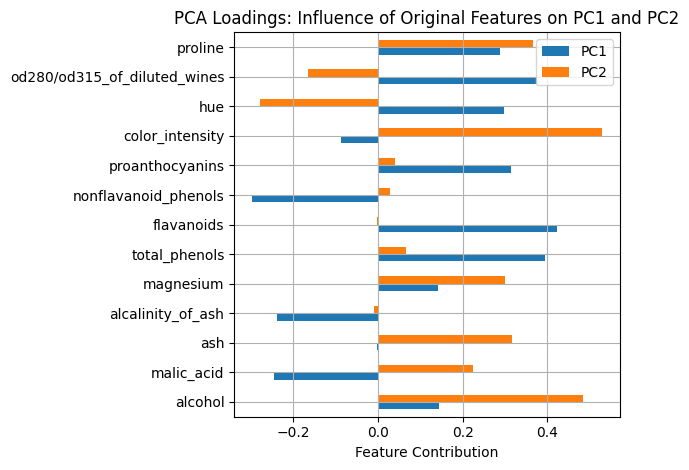

PC1 explains 36.20% of the variance
PC2 explains 19.21% of the variance
PC3 explains 11.12% of the variance
PC4 explains 7.07% of the variance
PC5 explains 6.56% of the variance

Top features contributing to PC1 and PC2:
                                   PC1       PC2
flavanoids                    0.422934 -0.003360
total_phenols                 0.394661  0.065040
od280/od315_of_diluted_wines  0.376167 -0.164496
proanthocyanins               0.313429  0.039302
hue                           0.296715 -0.279235


In [28]:
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f"PC{i+1}" for i in range(len(pca.components_))],
                        index=feature_names)

# Plotting
plt.figure(figsize=(10, 6))
loadings[['PC1', 'PC2']].plot(kind='barh')
plt.title("PCA Loadings: Influence of Original Features on PC1 and PC2")
plt.xlabel("Feature Contribution")
plt.grid(True)
plt.tight_layout()
plt.show()

for i, var_ratio in enumerate(pca.explained_variance_ratio_[:5]):
    print(f"PC{i+1} explains {var_ratio:.2%} of the variance")

# Print loading table
print("\nTop features contributing to PC1 and PC2:")
print(loadings[['PC1', 'PC2']].sort_values(by='PC1', ascending=False).head(5))

*Complete*
The first principal componemt is most influenced by proline and flavanoids. These features play a key role in separating the classes, particularly 0 from the others. PC2 is more influenced by color intensity and nonflavanoid phenols. This shows that different original features are important for classifying different wine types.